# 毕业项目：检测分神司机

In [1]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical
from keras import regularizers

from keras.applications import resnet50
from keras.applications.resnet50 import ResNet50


import pydot
import cv2
import h5py

d:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

resnet50_train_datagen = ImageDataGenerator(
    featurewise_std_normalization=True,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=resnet50.preprocess_input)

resnet50_valid_datagen = ImageDataGenerator(
    featurewise_std_normalization=True,
    preprocessing_function=resnet50.preprocess_input)


resnet50_train_generator = resnet50_train_datagen.flow_from_directory(
    image_train_folder_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

resnet50_valid_generator = resnet50_valid_datagen.flow_from_directory(
    image_valid_folder_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

d:\python35\lib\site-packages\keras\preprocessing\image.py:504: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20097 images belonging to 10 classes.
Found 2327 images belonging to 10 classes.


### 二、创建基准模型

In [3]:
def create_model_resnet50():
    model_resnet50 = ResNet50(include_top=False, weights='imagenet')

    print('Print resnet50 model summary:')
    print(model_resnet50.summary())

    for i in range(77):
        model_resnet50.layers[i].trainable = False
        
    input = Input(shape=(224, 224, 3),name = 'image_input')
 
    output_resnet50_conv = model_resnet50(input)
   
    x = GlobalAveragePooling2D()(output_resnet50_conv)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
    
    model = Model(input=input, output=x)
    
    adam = optimizers.Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

### 三、模型创建

In [4]:
model_resnet50_finetune_77 = create_model_resnet50()

Print resnet50 model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
_______________________________________________________________________________

d:\python35\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("im...)`


### 五、基准模型训练

In [5]:
history_resnet50_finetune_77 = model_resnet50_finetune_77.fit_generator(
    resnet50_train_generator,
    epochs=10,
    validation_data=resnet50_valid_generator)

Epoch 1/10


d:\python35\lib\site-packages\keras\preprocessing\image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
d:\python35\lib\site-packages\keras\preprocessing\image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


315/315 [==============================] - 245s 777ms/step - loss: 0.4720 - categorical_accuracy: 0.9137 - val_loss: 0.7225 - val_categorical_accuracy: 0.8320
Epoch 2/10
315/315 [==============================] - 237s 751ms/step - loss: 0.2029 - categorical_accuracy: 0.9927 - val_loss: 0.8176 - val_categorical_accuracy: 0.8028
Epoch 3/10
315/315 [==============================] - 238s 754ms/step - loss: 0.1649 - categorical_accuracy: 0.9943 - val_loss: 0.6431 - val_categorical_accuracy: 0.8505
Epoch 4/10
315/315 [==============================] - 237s 753ms/step - loss: 0.1417 - categorical_accuracy: 0.9921 - val_loss: 0.5672 - val_categorical_accuracy: 0.8702
Epoch 5/10
315/315 [==============================] - 238s 754ms/step - loss: 0.1118 - categorical_accuracy: 0.9966 - val_loss: 0.4466 - val_categorical_accuracy: 0.8762
Epoch 6/10
315/315 [==============================] - 237s 753ms/step - loss: 0.0910 - categorical_accuracy: 0.9971 - val_loss: 0.3906 - val_categorical_accuracy

In [6]:
model_resnet50_finetune_77.save(join(pardir, 'model', 'resnet50_finetune_77.h5'))
print("Resnet50 model saved.")

Resnet50 model saved.


{'loss': [0.4697652056768011, 0.19966877492060084, 0.1629812759612101, 0.13684423886739644, 0.10892006383699321, 0.08747462390661062, 0.0758608247460658, 0.06055197706802417, 0.051752760682336404, 0.04335488814907109], 'categorical_accuracy': [0.9134199134199135, 0.9926357167736478, 0.9942777528984426, 0.9952231676369607, 0.9966164104095139, 0.9970642384435487, 0.9970642384435487, 0.9976613424889287, 0.9974623078071354, 0.9983579638752053], 'val_categorical_accuracy': [0.831972496636087, 0.8027503223033949, 0.8504512246120217, 0.8702191663341662, 0.8762354962959994, 0.8990116026404593, 0.9041684571642398, 0.8659217874277391, 0.8904168454423502, 0.8758057586153946], 'val_loss': [0.722500394074047, 0.8175570431521997, 0.6431057508482562, 0.5672055569953246, 0.44663088712048826, 0.39062001695436216, 0.35386868954012207, 0.49322155864647543, 0.44153747592660864, 0.46769253578522096]}


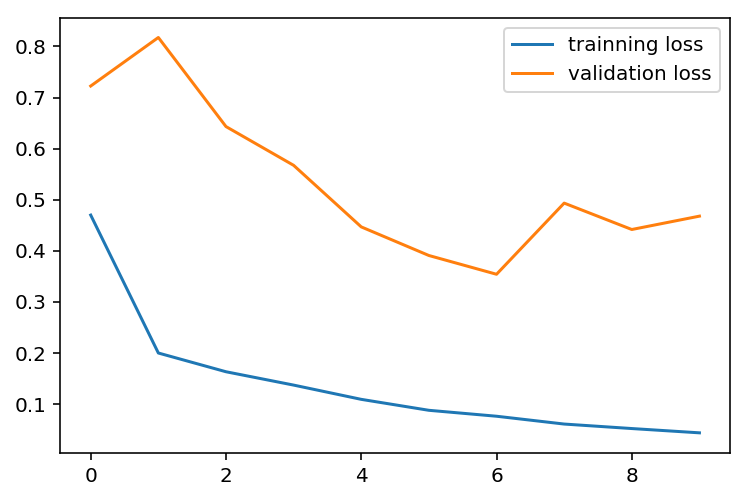

In [13]:
print (history_resnet50_finetune_77.history)
plt.plot (history_resnet50_finetune_77.history['loss'], label="trainning loss")
plt.plot (history_resnet50_finetune_77.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

### 六、基准模型评估

In [14]:
test_image_path = join(driver_dataset_folder_path, 'test')
resnet50_test_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
resnet50_test_generator = resnet50_test_datagen.flow_from_directory(
    test_image_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical')

model_resnet50_finetune_77 = load_model(join(pardir, 'model', 'resnet50_finetune_77.h5'))
print("Model loaded.")
pred_resnet50_finetune_77 = model_resnet50_finetune_77.predict_generator(resnet50_test_generator, verbose=1)
print(pred_resnet50_finetune_77.shape)

Found 79726 images belonging to 1 classes.
Model loaded.
2492/2492 [==============================] - 632s 254ms/step
(79726, 10)


### 六、生成kaggle提交文件

In [15]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [16]:
result_resnet50_finetune_77 = np.append(image_names, pred_resnet50_finetune_77, axis = 1)
predict_result_resnet50_finetune_77 = pd.DataFrame(result_resnet50_finetune_77, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_resnet50_finetune_77.to_csv('result_resnet50_finetune_77.csv', index=False)